# Deep aggregation with CoNAL (Common Noise Adaptation Layer)

In [1]:
import numpy as np
from pathlib import Path

In [2]:
DIR = Path().cwd()
DIRlabelme = (DIR / ".." / "datasets" / "labelme").resolve()
DIR_module = DIRlabelme / "labelme.py"
DIR_answers = DIRlabelme / "answers.json"
print(DIRlabelme)

/home/tlefort/Documents/peerannot/peerannot/datasets/labelme


# Running CoNAL CLI

In [3]:
! peerannot aggregate-deep -h

Usage: peerannot aggregate-deep [OPTIONS] [DATASET]

  Crowdsourcing strategy using deep learning models

Options:
  -K, --n-classes INTEGER   Number of classes to separate
  -o, --output-name TEXT    Name of the generated results file
  -s, --strategy TEXT       Deep learning strategy
  --model TEXT              Neural network to train on
  --answers PATH            Crowdsourced labels in json file
  --img-size INTEGER        Size of image (square)
  --pretrained              Use torch available weights to initialize the
                            network  [default: False]
  --n-epochs INTEGER        Number of training epochs
  --lr FLOAT                Learning rate
  --momentum FLOAT          Momentum for the optimizer
  --decay FLOAT             Weight decay for the optimizer
  --scheduler               Use a multistep scheduler for the learning rate
                            [default: False]
  -m, --milestones INTEGER  Milestones for the learning rate decay scheduler
  --n-para

The following command is an example on how to train CoNAL on labelme, but it is not advised to fully train the network here (long and costly)

```bash
! peerannot aggregate-deep $DIRlabelme -o labelme_conal --answers $DIR_answers -s conal[scale=1e-5] \
    --model modellabelme --img-size=224 --pretrained --n-classes=8 \
    --n-epochs=1000 --lr=5e-3 --optimizer=adam \
    --batch-size=32 --num-workers=8 --data-augmentation
```

# Loading trained CoNAL

In [4]:
import torch
from peerannot.models.CoNAL import CoNAL_net
from peerannot.helpers.networks import networks
clf = networks("modellabelme", n_classes=8)

Using cache found in /home/tlefort/.cache/torch/hub/pytorch_vision_main


Successfully loaded modellabelme with n_classes=8


In [5]:
checkpoint = torch.load(DIRlabelme / "best_models" / "labelme_conal.pth")
conal_our = CoNAL_net(input_dim=int(224 * 3 * 224),
                  n_class=8,
                  n_annotator=59,
                  classifier=clf,
                  annotator_dim=59,
                  embedding_dim=20)
conal_our.classifier.load_state_dict(checkpoint["classifier"])
conal_our.auxiliary_network.load_state_dict(checkpoint["auxiliary"])
conal_our.noise_adaptation_layer.load_state_dict(checkpoint["noise_adaptation"])

<All keys matched successfully>

# Majority vote and load dataset

In [ ]:
from peerannot.runners.train import load_all_data
labels_path = DIRlabelme / "labels" / "labels_labelme_mv.npy"
trainset, valset, testset = load_all_data(
    DIRmusic, labels_path, path_remove=None, labels=labels_path, img_size=224, data_augmentation=False)

# Visualize confusion matrices with CoNAL

In [6]:
from torchvision import datasets
dataset = datasets.ImageFolder(DIRlabelme / "train")
classes = dataset.class_to_idx

Keep in mind that the class numbers

In [7]:
import matplotlib.pyplot as plt

In [8]:
conf_local_our = conal_our.noise_adaptation_layer.local_confusion_matrices.detach(
).numpy()  # Confusion matrices of each annotator
conf_global_our = conal_our.noise_adaptation_layer.global_confusion_matrix.detach(
).numpy()  # Confusion matrix of common noise

In [9]:
list(classes.keys())

['coast',
 'forest',
 'highway',
 'insidecity',
 'mountain',
 'opencountry',
 'street',
 'tallbuilding']

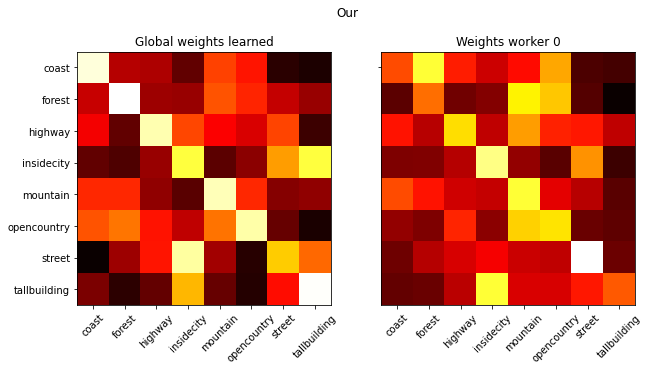

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(conf_global_our, cmap="hot")
axs[0].set_title("Global weights learned")
axs[0].xaxis.set_ticks(range(8))
axs[0].xaxis.set_ticklabels( list(classes.keys()), rotation=45)
axs[0].yaxis.set_ticks(range(8))
axs[0].yaxis.set_ticklabels( list(classes.keys()), rotation=0)

axs[1].imshow(conf_local_our[0], cmap="hot")
axs[1].set_title("Weights worker 0")
axs[1].xaxis.set_ticks(range(8))
axs[1].xaxis.set_ticklabels( list(classes.keys()), rotation=45)
axs[1].yaxis.set_ticks([0])
axs[1].yaxis.set_ticklabels("")
fig.suptitle("Our")
plt.show()